# Rice leaf disease detection prediction file

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sb
from sklearn.metrics import confusion_matrix

## Allocate memory to GPU for faster runtime

In [2]:
use_gpu = True

if use_gpu:
    phy_devices = tf.config.experimental.list_physical_devices('GPU')
    print(phy_devices)
    if phy_devices:
        print("Memory allocation and computations pushed to GPU env")
        tf.config.experimental.set_memory_growth(phy_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory allocation and computations pushed to GPU env


## Data Extraction

In [3]:
#dataset path
dataset_dir = 'D:/Andrei/Andrei/Prog Applications/datasets'
dataset_name = '/_Preprocessed_Rice diseases exclusively_with_valid'
dataset_dir = dataset_dir + dataset_name

#image details
class_names=['blast','blight','tungro']
size = (224, 224)
img_color_mode = 'rgb'
img_type = '.jpg'

In [4]:
N=[]
for i in range(len(class_names)):
    N+=[i]
    
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names)) 

def mapper(value):
    return reverse_mapping[value]

In [5]:
def get_testXYbatch(test_path, size=(224,224), batch_size=1):
    test_batch = tf.keras.utils.image_dataset_from_directory(
        directory=test_path, 
        image_size=size, 
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
    )

    X = []
    Y = []
    for images, labels in test_batch.take(-1):
        X.append(images.numpy()[0,:,:,:])
        Y.append(labels.numpy()[0])
    return np.array(X), np.array(Y), test_batch

In [6]:
testx, testy, testbatch = get_testXYbatch(f'{dataset_dir}/testing')

Found 48 files belonging to 3 classes.


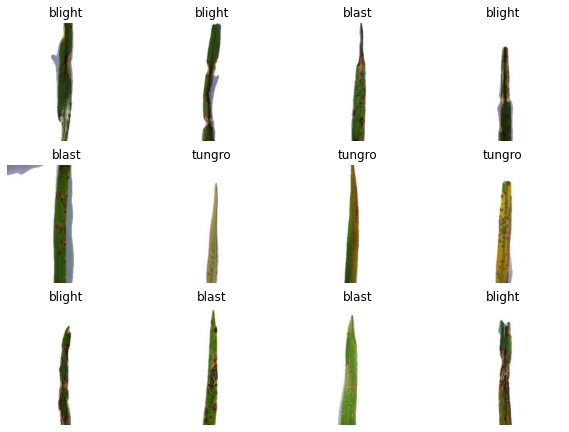

In [7]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    image = testx[i] 
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[np.argmax(testy[i], axis=-1)])
    plt.axis("off")

In [8]:
#normalize test data, only run this once
testx /= 255

## Load saved model

### Without Attention

In [9]:
saved_model_file_path = 'model_checkpoints/'
saved_model_name = "DenseBiLSTM_noAttention"
saved_model = tf.keras.models.load_model(saved_model_file_path + saved_model_name + '.h5')
saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

[Text(0, 0.5, 'blast'), Text(0, 1.5, 'blight'), Text(0, 2.5, 'tungro')]

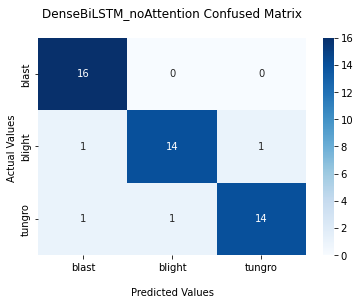

In [10]:
y_pred=saved_model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{saved_model_name} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [11]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.93      0.88      0.90        16
           2       0.93      0.88      0.90        16

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



In [12]:
saved_model.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

2/2 [==============================] - 5s 144ms/step - loss: 0.2106 - accuracy: 0.9167


[0.21061213314533234, 0.9166666865348816]

In [13]:
# image = load_img(f"{dataset_dir}/blight/IMG_1034.jpg",target_size=(224,224))
image1 = load_img(f"{dataset_dir}/testing/blight/_2_7097357.jpg",target_size=(224,224))
image2 = load_img(f"{dataset_dir}/testing/tungro/_2_9149343.jpg",target_size=(224,224))
image3 = load_img(f"{dataset_dir}/testing/blast/_3_5086811.jpg",target_size=(224,224))

image4 = load_img(f"{dataset_dir}/testing/blight/_11_5010550.jpg",target_size=(224,224))
image5 = load_img(f"{dataset_dir}/testing/tungro/_14_4884708.jpg",target_size=(224,224))
image6 = load_img(f"{dataset_dir}/testing/blast/_10_4011363.jpg",target_size=(224,224))

In [14]:
images_for_prediction = [
    image1,
    image2,
    image3,
    image4,
    image5,
    image6
]

i = 0
for image in images_for_prediction:
    image=img_to_array(image) 
    image=image/255
    prediction_image=np.array(image)
    prediction_image= np.expand_dims(image, axis=0)
    prediction=saved_model.predict(prediction_image)
    value=np.argmax(prediction)
    move_name=mapper(value)
    print(f"\n------Image {i} prediction------\n")
    print(prediction)
    print(value)
    print("\nPrediction is {}.".format(move_name))    
    i+=1


------Image 0 prediction------

[[6.575871e-04 9.992988e-01 4.362487e-05]]
1

Prediction is blight.

------Image 1 prediction------

[[1.9451334e-06 2.2763493e-02 9.7723460e-01]]
2

Prediction is tungro.

------Image 2 prediction------

[[9.9985480e-01 9.6356860e-05 4.8809117e-05]]
0

Prediction is blast.

------Image 3 prediction------

[[1.3619817e-05 9.9998522e-01 1.1572362e-06]]
1

Prediction is blight.

------Image 4 prediction------

[[3.7992641e-04 1.3776906e-06 9.9961865e-01]]
2

Prediction is tungro.

------Image 5 prediction------

[[9.9999940e-01 5.5819237e-07 3.6515019e-08]]
0

Prediction is blast.


### With Attention

In [ ]:
saved_model_file_path = 'model_checkpoints/'
saved_model_name = "DenseBiLSTM_withAttention"
#saved_model_name = "MoBiLSTM_withAttention"
saved_model = tf.keras.models.load_model(saved_model_file_path + saved_model_name + '.h5')
saved_model.summary()

In [ ]:
y_pred=saved_model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)

conf_matrix = confusion_matrix(ground, pred)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title(f'{saved_model_name} Confused Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [ ]:
print(classification_report(ground,pred))

In [ ]:
saved_model.evaluate(x=ImageDataGenerator().flow(testx, testy, batch_size=32), verbose = 1)

In [30]:
# image = load_img(f"{dataset_dir}/blight/IMG_1034.jpg",target_size=(224,224))
image1 = load_img(f"{dataset_dir}/testing/blight/_2_7097357.jpg",target_size=(224,224))
image2 = load_img(f"{dataset_dir}/testing/tungro/_2_9149343.jpg",target_size=(224,224))
image3 = load_img(f"{dataset_dir}/testing/blast/_3_5086811.jpg",target_size=(224,224))

image4 = load_img(f"{dataset_dir}/testing/blight/_11_5010550.jpg",target_size=(224,224))
image5 = load_img(f"{dataset_dir}/testing/tungro/_14_4884708.jpg",target_size=(224,224))
image6 = load_img(f"{dataset_dir}/testing/blast/_10_4011363.jpg",target_size=(224,224))

In [31]:
images_for_prediction = [
    image1,
    image2,
    image3,
    image4,
    image5,
    image6
]

i = 0
for image in images_for_prediction:
    image=img_to_array(image) 
    image=image/255
    prediction_image=np.array(image)
    prediction_image= np.expand_dims(image, axis=0)
    prediction=saved_model.predict(prediction_image)
    value=np.argmax(prediction)
    move_name=mapper(value)
    print(f"\n------Image {i} prediction------\n")
    print(prediction)
    print(value)
    print("\nPrediction is {}.".format(move_name))    
    i+=1


------Image 0 prediction------

[[0.01868181 0.97447103 0.00684716]]
1

Prediction is blight.

------Image 1 prediction------

[[2.3342075e-04 8.9415762e-04 9.9887246e-01]]
2

Prediction is tungro.

------Image 2 prediction------

[[9.9732363e-01 5.2247744e-04 2.1538727e-03]]
0

Prediction is blast.

------Image 3 prediction------

[[9.191590e-05 9.998523e-01 5.580965e-05]]
1

Prediction is blight.

------Image 4 prediction------

[[1.6283686e-04 2.1525771e-04 9.9962187e-01]]
2

Prediction is tungro.

------Image 5 prediction------

[[9.9933499e-01 2.7217172e-04 3.9278131e-04]]
0

Prediction is blast.
